In [1]:
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

# Transformer Block code
- reusing this code from my implementation of Karpathy's Nano GPT [here](https://github.com/HibernatingBunny067/MachineLearningFromScratch/tree/main/KarpathyLectures)
- here instead of using CausalAttention, we switch to SelfAttention (no masking)
- use patch-embeddings
- add cls_token

In [2]:
class FeedForward(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embed,4*config.embed),
            nn.ReLU(),
            nn.Linear(4*config.embed,config.embed),
            nn.Dropout(config.dropout)
        )
    def forward(self,x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.embed % config.n_heads == 0
        self.c_attn = nn.Linear(config.embed,3*config.embed,bias=False)
        self.proj = nn.Linear(config.embed,config.embed,bias=False)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_heads = config.n_heads
        self.n_embed = config.embed
    def forward(self,x):
        B,T,C = x.shape

        kqv = self.c_attn(x) ## x(B,T,C) -> kqv (B,T,3*C)

        k,q,v = kqv.split(self.n_embed,dim=2) ## each matrix has dimension (B,T,C)

        k = k.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## k(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)
        q = q.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## q(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)
        v = v.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## v(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)

        ##attention calculation for each head we want (T,head_size) which we'll concatenate

        wei = q @ k.transpose(-2,-1) * (k.shape[-1]**-0.5) ## wei: (B,n_heads,T,T)

        ##NO NEED FOR THESE LINES
        
        # trill = torch.tril(torch.ones(T,T,device=x.device)).view(1,1,T,T)
        # wei = wei.masked_fill(trill == 0,float('-inf'))

        ## CHANGES IN TRANSFORMERS
        
        wei = F.softmax(wei,dim=-1)
        wei = self.attn_dropout(wei)
        
        y = wei@v

        y = y.transpose(1,2).contiguous().view(B,T,C)

        out = self.proj(y)
        out = self.resid_dropout(out)
        return out

class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.sa = SelfAttention(config)
        self.ffwd = FeedForward(config)

        self.ln1 = nn.LayerNorm(config.embed)
        self.ln2 = nn.LayerNorm(config.embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


## Additional Patch Embeddings

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.img_size = config.img_size
        self.patch_size = config.patch_size

        self.proj = nn.Conv2d(
            config.in_channels,
            config.embed,
            kernel_size= config.patch_size,
            stride = self.patch_size
        )

        self.num_patches = (self.img_size//self.patch_size)**2

    def forward(self,x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

## VIT Mdoel

In [4]:
class ViT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.patch_embed = PatchEmbed(config)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1,1,config.embed))
        self.pos_embed = nn.Parameter(torch.zeros(1,num_patches+1,config.embed))
        self.pos_drop = nn.Dropout(config.dropout)


        self.blocks = nn.Sequential(
            *[Block(config) for _ in range(config.n_layers)]
        )

        self.ln_f = nn.LayerNorm(config.embed)
        self.head = nn.Linear(config.embed,config.n_classes)

    def forward(self,x):
        B,C,H,w = x.shape

        x = self.patch_embed(x)
        cls = self.cls_token.expand(B,-1,-1)

        x = torch.cat((cls,x),dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.blocks(x)
        x =self.ln_f(x)
        cls_out = x[:,0]
        out = self.head(cls_out)

        return out

## Defining Config

In [5]:
@dataclass
class config:
    img_size = 224
    patch_size = 16
    in_channels = 3

    embed = 768
    n_heads = 12
    n_layers=12
    dropout=0.1

    n_classes = 5

## testing

In [6]:
model = ViT(config)
x = torch.randn((8,3,224,224))
output = model(x)

assert output.shape[0] == 8
assert output.shape[1] == config.n_classes
del model

# Model Training
- training on CIFAR-10

## Downloading Dataset

In [8]:
import torchvision
from torchvision.transforms import transforms as T

transform = T.Compose([
    T.Resize(32),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,)*3, (0.5,)*3),
])

transformv = T.Compose([
    T.Resize(32),
    T.RandomCrop(32, padding=4),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,)*3, (0.5,)*3),
])
trainset = torchvision.datasets.CIFAR10(
    root = './data',
    train=True,
    download=True,
    transform = transform
)

testset = torchvision.datasets.CIFAR10(
    root = './data',
    train=False,
    download=True,
    transform=transformv
)

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2,pin_memory=True)
val_loader = DataLoader(testset,batch_size=256,shuffle=False,num_workers=0)

## Defining Model

In [15]:
@dataclass
class config:
    img_size = 32
    patch_size = 4
    in_channels = 3

    embed = 768
    n_heads = 12
    n_layers = 16
    dropout = 0.2

    n_classes = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ViT(config).to(DEVICE)

## Training Loop

In [16]:
##Hyperparameters
from transformers import get_cosine_schedule_with_warmup

num_epochs = 20
warmup_ratio = 0.04
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(),lr,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()


num_training_steps = num_epochs*len(train_loader)
num_warmup_steps = int(warmup_ratio*num_training_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = num_warmup_steps,
                                            num_training_steps=num_training_steps)

In [17]:
from tqdm.notebook import tqdm, trange
import numpy as np
import torch

patience = 3
trigger = 0
best_val_loss = float('inf')

training_loss = []
validation_loss = []

for epoch in trange(num_epochs):

    # -------- TRAIN --------
    model.train()
    epoch_tr_loss = []

    loader = tqdm(train_loader, leave=False)
    for img, labels in loader:
        img = img.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()       

        y = model(img)
        loss = criterion(y, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()               # if using per-batch scheduler

        epoch_tr_loss.append(loss.item())
        loader.set_postfix(train_loss=f"{loss.item():.4f}")

    train_loss = np.mean(epoch_tr_loss)
    training_loss.append(train_loss)

    # -------- VALIDATION --------
    model.eval()
    epoch_val_loss = []

    correct = 0
    total = 0

    with torch.no_grad():
        for img, labels in val_loader:
            img = img.to(DEVICE)
            labels = labels.to(DEVICE)

            y = model(img)
            loss = criterion(y, labels)

            epoch_val_loss.append(loss.item())

            preds = y.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = np.mean(epoch_val_loss)
    val_acc = correct / total

    validation_loss.append(val_loss)

    print(
        f"EPOCH: {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger = 0
        torch.save(model.state_dict(), "best_vit.pt")
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping triggered.")
            break


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1/20 | Train Loss: 1.9040 | Val Loss: 1.6730 | Val Acc: 0.3760


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 2/20 | Train Loss: 1.6123 | Val Loss: 1.5371 | Val Acc: 0.4401


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 3/20 | Train Loss: 1.4452 | Val Loss: 1.4010 | Val Acc: 0.4847


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 4/20 | Train Loss: 1.3636 | Val Loss: 1.2890 | Val Acc: 0.5280


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 5/20 | Train Loss: 1.3072 | Val Loss: 1.2540 | Val Acc: 0.5467


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 6/20 | Train Loss: 1.2718 | Val Loss: 1.2321 | Val Acc: 0.5536


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 7/20 | Train Loss: 1.2309 | Val Loss: 1.2024 | Val Acc: 0.5614


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 8/20 | Train Loss: 1.1977 | Val Loss: 1.1506 | Val Acc: 0.5785


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 9/20 | Train Loss: 1.1649 | Val Loss: 1.1362 | Val Acc: 0.5905


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 10/20 | Train Loss: 1.1295 | Val Loss: 1.1422 | Val Acc: 0.5844


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 11/20 | Train Loss: 1.0994 | Val Loss: 1.0785 | Val Acc: 0.6104


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 12/20 | Train Loss: 1.0633 | Val Loss: 1.0548 | Val Acc: 0.6191


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 13/20 | Train Loss: 1.0339 | Val Loss: 1.0163 | Val Acc: 0.6340


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 14/20 | Train Loss: 1.0008 | Val Loss: 0.9964 | Val Acc: 0.6438


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 15/20 | Train Loss: 0.9743 | Val Loss: 0.9982 | Val Acc: 0.6468


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 16/20 | Train Loss: 0.9487 | Val Loss: 0.9501 | Val Acc: 0.6645


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 17/20 | Train Loss: 0.9230 | Val Loss: 0.9603 | Val Acc: 0.6582


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 18/20 | Train Loss: 0.9074 | Val Loss: 0.9298 | Val Acc: 0.6686


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 19/20 | Train Loss: 0.8964 | Val Loss: 0.9306 | Val Acc: 0.6695


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 20/20 | Train Loss: 0.8930 | Val Loss: 0.9365 | Val Acc: 0.6603


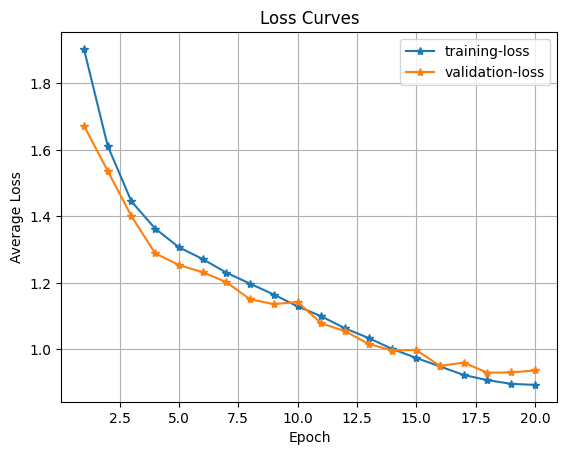

In [26]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,21,1),training_loss,marker='*',label='training-loss')
plt.plot(np.arange(1,21,1),validation_loss,marker='*',label='validation-loss')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid()

- training a little bit longer would help !